In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import torch

In [9]:
# Load the metadata
file_path_metadata = '/home/parkej95/CSE283/AD_prediction_blood/silver_seq/silver_seq_metadata.xlsx'
metadata = pd.read_excel(file_path_metadata)

# Load the RNA-seq data from a text file
file_path_rna_seq = '/home/parkej95/CSE283/AD_prediction_blood/silver_seq/silver_seq_counts.txt'
rna_seq_data = pd.read_csv(file_path_rna_seq, sep='\t', index_col=0)  # Adjust sep if necessary

# Transpose RNA-seq data to have samples as rows and genes as columns
rna_seq_data = rna_seq_data.T

# Normalize the RNA-seq data (e.g., using StandardScaler)
scaler = StandardScaler()
rna_seq_data_scaled = scaler.fit_transform(rna_seq_data)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)  # Adjust n_components as needed
rna_seq_pca = pca.fit_transform(rna_seq_data_scaled)

# Convert PCA result to DataFrame and add sample identifiers
rna_seq_pca_df = pd.DataFrame(rna_seq_pca, index=rna_seq_data.index)
rna_seq_pca_df.reset_index(inplace=True)
rna_seq_pca_df.rename(columns={'index': 'sample_id_alias'}, inplace=True)

# Merge metadata with RNA-seq PCA data on 'sample_id_alias'
merged_data = pd.merge(metadata, rna_seq_pca_df, on='sample_id_alias')

# Display the first few rows of the merged dataframe
# print(merged_data.head())

# Step 1: Label Encoding
label_encoder = LabelEncoder()
merged_data['donor_group'] = label_encoder.fit_transform(merged_data['donor_group'])

# Step 2: Feature Selection
# Use all columns except 'donor_id', 'donor_id_alias', 'sample_id_alias', 'year_sample', and 'donor_group' as features
features = merged_data.drop(columns=['donor_id', 'donor_id_alias', 'sample_id_alias', 'year_sample', 'donor_group', 'donor_status_score', 'braak_stage', 'apoe_dose'])
print(features.head())
target = merged_data['donor_group']

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Convert boolean features to integers
features = features.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Ensure all features are numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaNs with 0
features = features.fillna(0)

# Verify data types
print(features.dtypes)

# Step 3: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

   apoe apoe_carrier          0         1         2
0    34        apoe4 -45.553437 -2.990394 -0.090256
1    34        apoe4 -49.274715 -1.400349 -2.482614
2    34        apoe4 -19.796124 -0.349106 -4.060041
3    34        apoe4  13.826900 -2.356997 -6.100501
4    34        apoe4  38.330519 -1.461772 -1.386204
apoe                       int64
0                        float64
1                        float64
2                        float64
apoe_carrier_no_apoe4      int64
dtype: object


In [10]:
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [11]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = 2  # Binary classification: AD or N

model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the test set after each epoch
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, targets in test_loader:
            # Move data to GPU
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, F1 Score: {f1:.4f}')

# Evaluate the model and calculate AUC
model.eval()
all_targets = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

accuracy = 100 * correct / total

# Calculate AUC
auc = roc_auc_score(all_targets, all_probabilities)

print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'AUC of the model on the test set: {auc:.4f}')

Epoch [1/50], Loss: 0.7844, F1 Score: 0.5300
Epoch [2/50], Loss: 0.8430, F1 Score: 0.6619
Epoch [3/50], Loss: 0.6560, F1 Score: 0.6886
Epoch [4/50], Loss: 0.6280, F1 Score: 0.6619
Epoch [5/50], Loss: 0.6530, F1 Score: 0.7009
Epoch [6/50], Loss: 0.6292, F1 Score: 0.6230
Epoch [7/50], Loss: 0.6047, F1 Score: 0.6619
Epoch [8/50], Loss: 0.9582, F1 Score: 0.7623
Epoch [9/50], Loss: 0.6489, F1 Score: 0.7369
Epoch [10/50], Loss: 0.8759, F1 Score: 0.7014
Epoch [11/50], Loss: 0.8493, F1 Score: 0.7623
Epoch [12/50], Loss: 0.5932, F1 Score: 0.6522
Epoch [13/50], Loss: 1.0109, F1 Score: 0.6317
Epoch [14/50], Loss: 0.5679, F1 Score: 0.6522
Epoch [15/50], Loss: 0.4324, F1 Score: 0.6619
Epoch [16/50], Loss: 0.5481, F1 Score: 0.6619
Epoch [17/50], Loss: 0.8481, F1 Score: 0.6522
Epoch [18/50], Loss: 0.5724, F1 Score: 0.6334
Epoch [19/50], Loss: 1.4404, F1 Score: 0.7369
Epoch [20/50], Loss: 1.2786, F1 Score: 0.5803
Epoch [21/50], Loss: 1.0194, F1 Score: 0.6619
Epoch [22/50], Loss: 0.7079, F1 Score: 0.53

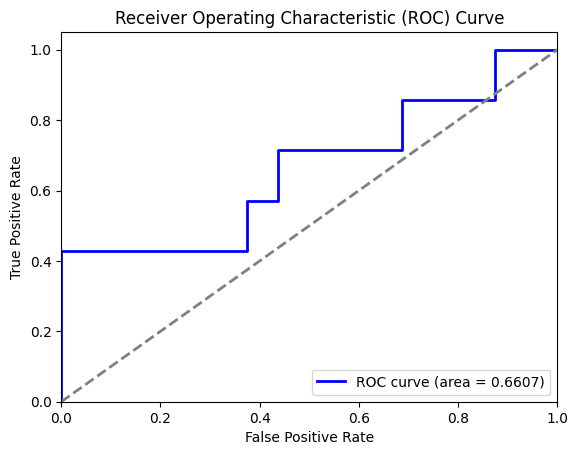

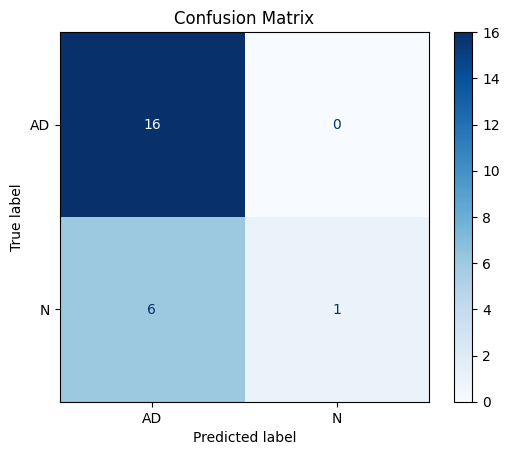

In [12]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()